## CS310 Natural Language Processing
## Assignment 3. Recurrent Neural Networks for Language Modeling (LSTM Version)

**Total points**: 

In this assignment, you will train an LSTM-based language model on the Harry Potter text data.

In [10]:
# LSTM on Harry_Potter_all_books_preprocessed.txt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re
import random
import nltk
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from collections import Counter
from utils import build_training_visualization

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # 只使用GPU 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [24]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT_RATE = 0.2
BATCH_SIZE = 64
SEQ_LENGTH = 50
LEARNING_RATE = 0.001
NUM_EPOCHS = 10  
MIN_WORD_FREQ = 2

DATA_PATH = './Harry_Potter_all_books_preprocessed.txt'

VISUALIZATION_PATH = './lstm_lm_training.png'

# RANDOM_MODEL_PATH = './lstm_random_emb_model.pth'
RANDOM_MODEL_PATH = '/home/stu_12310401/nlp/SUSTech-NLP25-clean/Ass3/lstm_lm_model-random200.pth'
# PRETRAINED_MODEL_PATH = './lstm_pretrained_emb_model.pth'
PRETRAINED_MODEL_PATH = '/home/stu_12310401/nlp/SUSTech-NLP25-clean/Ass3/lstm_lm_model_pretrained200.pth'

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [12]:
def load_glove_embeddings(word_to_idx, embedding_dim=200):
    print("加载 GloVe 嵌入...")
    glove_model = api.load("glove-wiki-gigaword-200")
    
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    found_words = 0
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
            found_words += 1
    
    print(f"在 GloVe 嵌入中找到 {found_words}/{len(word_to_idx)} 个词")
    return embedding_matrix

In [13]:
def load_and_preprocess_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    tokens = word_tokenize(text)
    
    word_counts = Counter(tokens)
    vocab = ['<PAD>', '<UNK>', '<START>', '<END>'] + [word for word, count in word_counts.most_common() if count >= MIN_WORD_FREQ]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}
    
    text_indices = []
    for token in tokens:
        if token in word_to_idx:
            text_indices.append(word_to_idx[token])
        else:
            text_indices.append(word_to_idx['<UNK>'])
    
    return ' '.join(tokens), text_indices, word_to_idx, idx_to_word, len(vocab)

In [14]:
class TextDataset(Dataset):
    def __init__(self, text_indices, seq_length):
        self.text_indices = text_indices
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.text_indices) - self.seq_length
    
    def __getitem__(self, idx):
        sequence = self.text_indices[idx:idx+self.seq_length]
        target = self.text_indices[idx+1:idx+self.seq_length+1]
        
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate,pretrained_embeddings=None):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            print("预训练嵌入加载成功")
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
            
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_dim))

In [16]:
def train(model, dataloader, criterion, optimizer, clip_value=5.0):
    model.train()
    total_loss = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        hidden = model.init_hidden(inputs.size(0))
        
        optimizer.zero_grad()
        
        outputs, hidden = model(inputs, hidden)
        
        outputs = outputs.reshape(-1, outputs.size(2))
        targets = targets.reshape(-1)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [17]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            hidden = model.init_hidden(inputs.size(0))
            
            outputs, hidden = model(inputs, hidden)
            
            outputs = outputs.reshape(-1, outputs.size(2))
            targets = targets.reshape(-1)
            
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [18]:
def generate_text(model, seed_text, word_to_idx, idx_to_word, length=20, temperature=1.0):
    model.eval()
    
    seed_tokens = word_tokenize(seed_text)
    
    seed_indices = []
    for token in seed_tokens:
        if token in word_to_idx:
            seed_indices.append(word_to_idx[token])
        else:
            seed_indices.append(word_to_idx['<UNK>'])
    
    if len(seed_indices) < SEQ_LENGTH:
        seed_indices = [word_to_idx['<PAD>']] * (SEQ_LENGTH - len(seed_indices)) + seed_indices
    elif len(seed_indices) > SEQ_LENGTH:
        seed_indices = seed_indices[-SEQ_LENGTH:]
    
    current_indices = seed_indices.copy()
    generated_tokens = seed_tokens.copy()
    
    hidden = model.init_hidden(1)
    
    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor([current_indices], dtype=torch.long).to(device)
            output, hidden = model(x, hidden)
            
            output = output[0, -1, :] / temperature
            probabilities = torch.softmax(output, dim=0)
            
            next_index = torch.multinomial(probabilities, 1).item()
            
            generated_tokens.append(idx_to_word[next_index])
            
            current_indices = current_indices[1:] + [next_index]
    
    return ' '.join(generated_tokens)

In [19]:
def generate_text_greedy(model, seed_text, word_to_idx, idx_to_word, length=20):
    model.eval()
    
    # 对种子文本进行分词
    seed_tokens = word_tokenize(seed_text)
    
    # 转换为索引
    seed_indices = []
    for token in seed_tokens:
        if token in word_to_idx:
            seed_indices.append(word_to_idx[token])
        else:
            seed_indices.append(word_to_idx['<UNK>'])
    
    if len(seed_indices) < SEQ_LENGTH:
        seed_indices = [word_to_idx['<PAD>']] * (SEQ_LENGTH - len(seed_indices)) + seed_indices
    elif len(seed_indices) > SEQ_LENGTH:
        seed_indices = seed_indices[-SEQ_LENGTH:]
    
    current_indices = seed_indices.copy()
    generated_tokens = seed_tokens.copy()
    
    hidden = model.init_hidden(1)
    
    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor([current_indices], dtype=torch.long).to(device)
            output, hidden = model(x, hidden)
            
            output = output[0, -1, :]
            
            next_index = torch.argmax(output).item()
            
            generated_tokens.append(idx_to_word[next_index])
            
            current_indices = current_indices[1:] + [next_index]
    
    return ' '.join(generated_tokens)

In [20]:
def calculate_perplexity(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Calculating Perplexity"):
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = model.init_hidden(inputs.size(0))
            outputs, _ = model(inputs, hidden)
            
            outputs = outputs.reshape(-1, outputs.size(2))
            targets = targets.reshape(-1)
            
            loss = criterion(outputs, targets)
            total_loss += loss.item() * targets.size(0)
            total_words += targets.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

In [21]:
print("Loading and preprocessing data...")
text, text_indices, word_to_idx, idx_to_word, vocab_size = load_and_preprocess_data(DATA_PATH)
print(f"Vocabulary size: {vocab_size}")

dataset = TextDataset(text_indices, SEQ_LENGTH)

total_size = len(dataset)
train_size = int(0.9 * total_size)
val_size = int(0.05 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading and preprocessing data...


Vocabulary size: 18365


In [25]:
# Load pretrained embeddings long time to download
pretrained_embeddings = load_glove_embeddings(word_to_idx, EMBEDDING_DIM)

# Initialize models
random_model = LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT_RATE).to(device)
pretrained_model = LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT_RATE, 
                            pretrained_embeddings=pretrained_embeddings).to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
random_optimizer = optim.Adam(random_model.parameters(), lr=LEARNING_RATE)
pretrained_optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)

加载 GloVe 嵌入...
在 GloVe 嵌入中找到 12789/18365 个词
预训练嵌入加载成功


In [28]:
# 从检查点加载模型
if os.path.exists(RANDOM_MODEL_PATH):
    print(f"Loading checkpoint from {RANDOM_MODEL_PATH}")
    checkpoint = torch.load(RANDOM_MODEL_PATH)
    random_model.load_state_dict(checkpoint['model_state_dict'])
    random_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    random_model.eval()  
    print(random_model)
    print(f"train_loss is {train_loss}")


Loading checkpoint from /home/stu_12310401/nlp/SUSTech-NLP25-clean/Ass3/lstm_lm_model-random200.pth
LSTMModel(
  (embedding): Embedding(18365, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=18365, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
train_loss is 3.5507739315215696


/tmp/ipykernel_2411263/3170455105.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(RANDOM_MODEL_PATH)


In [34]:
if os.path.exists(PRETRAINED_MODEL_PATH):
    print(f"Loading checkpoint from {PRETRAINED_MODEL_PATH}")
    checkpoint = torch.load(PRETRAINED_MODEL_PATH)
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    pretrained_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    pretrained_model.eval()  
    print(pretrained_model)
    print(f"train_loss is {train_loss}")

Loading checkpoint from /home/stu_12310401/nlp/SUSTech-NLP25-clean/Ass3/lstm_lm_model_pretrained200.pth
LSTMModel(
  (embedding): Embedding(18365, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=18365, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
train_loss is 3.4858402025123194


/tmp/ipykernel_2411263/2227843158.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_MODEL_PATH)


In [29]:

# Training loop
print("Starting training...")
random_train_losses = []
random_val_losses = []
pretrained_train_losses = []
pretrained_val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train and evaluate random model
    print("Training model with random embeddings...")
    random_train_loss = train(random_model, train_dataloader, criterion, random_optimizer)
    random_val_loss = evaluate(random_model, val_dataloader, criterion)
    random_train_losses.append(random_train_loss)
    random_val_losses.append(random_val_loss)
    
    # Train and evaluate pretrained model
    print("Training model with pretrained embeddings...")
    pretrained_train_loss = train(pretrained_model, train_dataloader, criterion, pretrained_optimizer)
    pretrained_val_loss = evaluate(pretrained_model, val_dataloader, criterion)
    pretrained_train_losses.append(pretrained_train_loss)
    pretrained_val_losses.append(pretrained_val_loss)
    
    print(f"Random Embeddings - Train Loss: {random_train_loss:.4f}, Val Loss: {random_val_loss:.4f}")
    print(f"Pretrained Embeddings - Train Loss: {pretrained_train_loss:.4f}, Val Loss: {pretrained_val_loss:.4f}")
    
    # Save model checkpoints
    
    # torch.save({
    #     'epoch': epoch,
    #     'model_state_dict': random_model.state_dict(),
    #     'optimizer_state_dict': random_optimizer.state_dict(),
    #     'train_loss': random_train_loss,
    #     'val_loss': random_val_loss,
    # }, RANDOM_MODEL_PATH)
    # torch.save({
    #     'epoch': epoch,
    #     'model_state_dict': pretrained_model.state_dict(),
    #     'optimizer_state_dict': pretrained_optimizer.state_dict(),
    #     'train_loss': pretrained_train_loss,
    #     'val_loss': pretrained_val_loss,
    # }, PRETRAINED_MODEL_PATH)

Starting training...
Epoch 1/10
Training model with random embeddings...


Training:   1%|          | 103/15552 [00:04<10:59, 23.43it/s]


KeyboardInterrupt: 

In [35]:
random_test_perplexity = calculate_perplexity(random_model, test_dataloader, criterion)
pretrained_test_perplexity = calculate_perplexity(pretrained_model, test_dataloader, criterion)
print(f"Random embedding test perplexity: {random_test_perplexity:.2f}")
print(f"Pretrained embedding test perplexity: {pretrained_test_perplexity:.2f}")


Calculating Perplexity: 100%|██████████| 864/864 [00:07<00:00, 116.59it/s]

Random embedding test perplexity: 18.17
Pretrained embedding test perplexity: 16.52


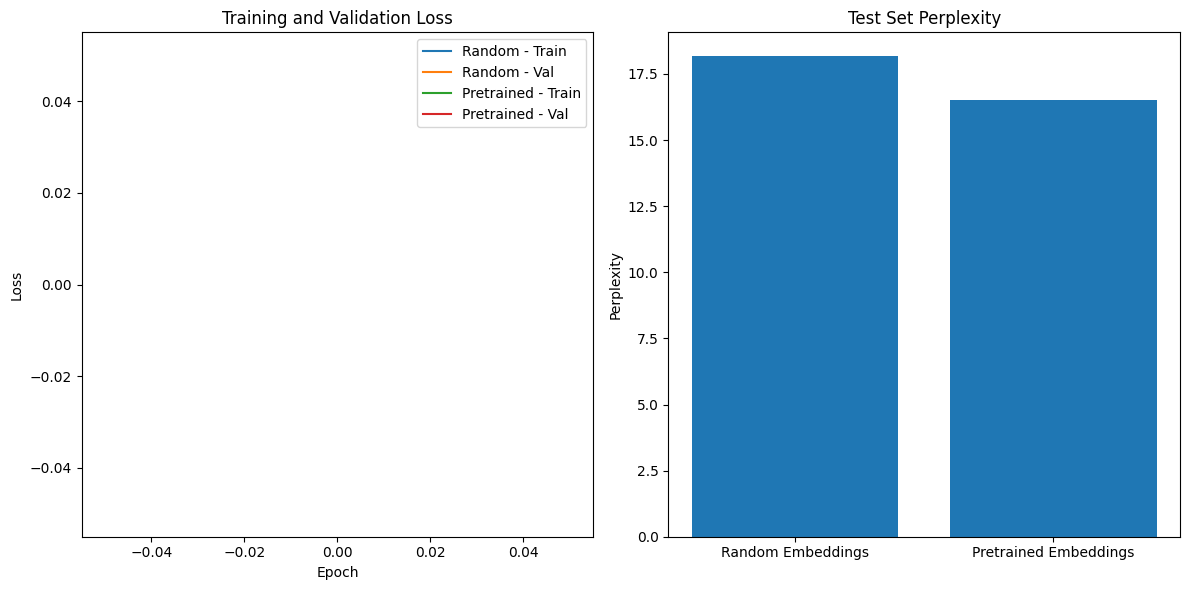

In [36]:
# Plot training loss curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(random_train_losses, label='Random - Train')
plt.plot(random_val_losses, label='Random - Val')
plt.plot(pretrained_train_losses, label='Pretrained - Train')
plt.plot(pretrained_val_losses, label='Pretrained - Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['Random Embeddings', 'Pretrained Embeddings'], 
        [random_test_perplexity, pretrained_test_perplexity])
plt.ylabel('Perplexity')
plt.title('Test Set Perplexity')

plt.tight_layout()
plt.savefig(VISUALIZATION_PATH)
plt.show()

In [37]:
print("\nGenerating sentences using greedy search:")
prefixes = ['Harry look', 'Hermione open', 'Ron run', 'Magic is', 'Professor Dumbledore']

for prefix in prefixes:
    generated_text = generate_text_greedy(random_model, prefix, word_to_idx, idx_to_word, length=15)
    print(f"Prefix: '{prefix}'")
    print(f"Generated: '{generated_text}'")
    print("-" * 50)


Generating sentences using greedy search:
Prefix: 'Harry look'
Generated: 'Harry look like a pig ! said Hermione angrily .I dont know what it meant .Xenophilius was'
--------------------------------------------------
Prefix: 'Hermione open'
Generated: 'Hermione open ? said Ron who was now shoveling mashed potato into his face .I dont know'
--------------------------------------------------
Prefix: 'Ron run'
Generated: 'Ron run ? said Ron who was now shoveling mashed potato into his face .I dont know'
--------------------------------------------------
Prefix: 'Magic is'
Generated: 'Magic is ? said Harry quickly .Yep said Harry firmly .I dont know what hes doing said'
--------------------------------------------------
Prefix: 'Professor Dumbledore'
Generated: 'Professor Dumbledore ? said Ron looking at the dense black boundary of the graveyard .He was a'
--------------------------------------------------
